## 🧠💡 Intelligent Systems  for Smart Health 👨‍⚕👩‍⚕️🔬🌡️


# Portfolio Exercise 01

<a name='import'></a>
## Import Packages

We'll first import all the common packages that we need for this assignment. 

- `shap` is a library that explains predictions made by machine learning models.
- `sklearn` is one of the most popular machine learning libraries.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [108]:
#!pip install lifelines

In [109]:
import os
import shap
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

<a name='1'></a>
## 1. The Dataset

We will (again) work with actual medical data in this notebook, namely the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)).

This time we will work with data from the period 2017-2018 which was downloaded via the pip package `nhanes` [GitHub link](https://github.com/poldrack/nhanes).

Most features are described within the GitHub repository. Some important information on the provided features:

- `Gender` - 1 is female, 0 is male
- `diabetes` - 1 means diabetes was diagnosed
- `diabetes_borderline` - 1 means "borderline diabetes" (close to having diabetes) was diagnosed
- `Smoking` - 1 means person has smoked within the last 5 days. People with missing entries were set to 0
- `PhysicalActivity` - 0 means no particular activities, 1 means "moderate recreational activities" or walking, biking and 2 means more extensive recreational activities
- `SEQN` is an ID


### Load and explore the data!

In virtually all cases, we would first want to get an intuition on the data itself. Things like: What is in the data? How much data is there? Are there things missing? What might cause problems? Do we understand the type of data/features?



In [110]:
path_data = "../data/" # add your own path

In [111]:
filename = "NHANES_2017_2018_diabetes.csv"
data = pd.read_csv(os.path.join(path_data, filename))

In [112]:
data.head()

,SEQN,Gender,AgeInYearsAtScreening,HaveSeriousDifficultySeeing,HaveSeriousDifficultyHearing,WeightKg,StandingHeightCm,BodyMassIndexKgm2,BloodMercuryTotalUgl,BloodManganeseUgl,...,TotalSugarsGm_DR1TOT,BloodLeadUgdl,60SecPulse30SecPulse2,DirectHdlcholesterolMgdl,TotalCholesterolMgdl,SystolicBloodPres2NdRdgMmHg,Smoking,PhysicalActivity,diabetes,diabetes_borderline
0,93703.0,1,2.0,0.0,0.0,13.7,88.6,17.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0
1,93704.0,0,2.0,0.0,0.0,13.9,94.2,15.7,0.47,9.41,...,76.97,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0
2,93705.0,1,66.0,0.0,0.0,79.5,158.3,31.7,1.07,8.57,...,91.55,2.98,52.0,60.0,157.0,NaN,0,1.0,0,0
3,93706.0,0,18.0,0.0,0.0,66.3,175.7,21.5,10.64,14.07,...,14.73,0.74,82.0,47.0,148.0,114.0,0,1.0,0,0
4,93707.0,0,13.0,0.0,0.0,45.4,158.4,18.1,0.20,12.60,...,84.22,0.39,100.0,68.0,189.0,128.0,0,0.0,0,0


---

# Submission:

### 1. load and inspect the data 
- what are missing/problematic entries?

The next codeblock shows the number of null entries for every column. We can't say for sure if these features were diagnosed or not:

In [113]:
data.isnull().sum()

SEQN                                          0
Gender                                        0
AgeInYearsAtScreening                         0
HaveSeriousDifficultySeeing                   1
HaveSeriousDifficultyHearing                  1
WeightKg                                    124
StandingHeightCm                            350
BodyMassIndexKgm2                           361
BloodMercuryTotalUgl                        853
BloodManganeseUgl                           853
BloodSeleniumUgl                            853
BloodCadmiumUgl                             853
AnnualFamilyIncome                         1034
AlcoholGm_DR1TOT                           1081
CholesterolMg_DR1TOT                       1081
TotalPolyunsaturatedFattyAcidsGm_DR1TOT    1081
TotalMonounsaturatedFattyAcidsGm_DR1TOT    1081
TotalSaturatedFattyAcidsGm_DR1TOT          1081
TotalFatGm_DR1TOT                          1081
TotalSugarsGm_DR1TOT                       1081
BloodLeadUgdl                           

---

### 2. data cleaning 
- remove, fill, change data (if you think this makes sense or is necessary/benefitial)

It is better to clean the data from these null values. This way we train the model only on diagnoses, that we are certain about.

In [114]:
print("Shape of full dataset: ", data.shape)
data_cleaned = data.dropna()
print("Dropping all null values reduces the data to", data_cleaned.shape)

Shape of full dataset:  (8366, 29)
Dropping all null values reduces the data to (4905, 29)


As we can see dropping all null values reduces the data significantly and less data will result in a worse model. But it will still result in abetter model, than trying to predict an outcome on random data. Filling these values would be no good idea either, since we can't extrapolate diagnoses from the other features.

---

### 3. inspect correlations among the features 
- which features do you expect to play a role for a later machine learning model (for predicting diabetes), and why?

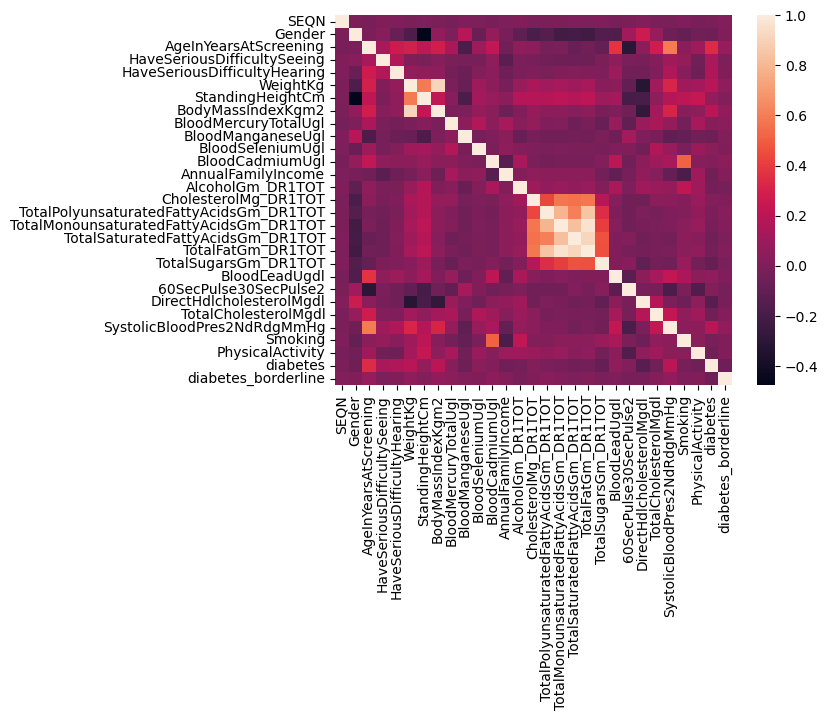

In [115]:
sns.heatmap(data_cleaned.corr(), xticklabels=True, yticklabels=True)
plt.show()

The correlation matrix shows high correlations where the squares are brighter. We can see that the Body Mass Index has high correlations to WeightKG and StandingHeightCm for the obvious reason that it is the ratio of the two. 
I expect features that have high correlations with the diabetes row to have high importance for the model. Age has the highest correlation. Also Body Mass Index and WeightKG have high correlations with diabetes, but StandingHeightCm has not. This could mean that WeightKG is the decisive factor of the BMI correlation.SystolicBloodPres2NdRdgMmHg has also a high correlation.
There might also be interactions between two or more features leading to diabetes, which is not visible in the correlation matrix. For example DirectHdlcholestrolMgdl has low correltion with diabetes but may have a high impact in combination with another feature. After all, one reason to train a model is to find these hidden interactions.


---
### 4. Prepare data for machine learning: 
- Separate data / labels
- Split into train ~70% / validation ~15% / test ~15%


In [116]:
# seperate labels
y = data_cleaned['diabetes']
# seperate data
X = data_cleaned.drop(['diabetes'], axis=1)

In [117]:
# split train and test data into 70% and 30% respectively
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=42)
# split the 30% test data into 15% and 15% for validation and test respectively
y_test, y_val, X_test, X_val = train_test_split(y_test, X_test, test_size=0.5, random_state=42)

# check the distribution after the split
print(X_test.shape, X_val.shape, X_train.shape)
print(y_test.shape, y_val.shape, y_train.shape)

print("Train data share: ", y_train.shape[0] / y.shape[0])
print("Test data share: ", y_test.shape[0] / y.shape[0])
print("Validation data share: ", y_val.shape[0]/ y.shape[0])

(736, 28) (736, 28) (3433, 28)
(736,) (736,) (3433,)
Train data share:  0.6998980632008155
Test data share:  0.15005096839959225
Validation data share:  0.15005096839959225


---
### 5. Train a first model (random forest)
- use validation and training set to avoid overfitting
- optimize your hyperparameters with a simple grid search
- Evaluate the model using accuracy, confusion matrix, f1-score, and ROC curve
- How good is the model? What are the main problems?

#### <a id='first_training'>5.1 First Training</a>

We will train a first model with some parameters to see what is possible with our data.

In [118]:
# train model
model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

In [119]:
import lifelines

def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)

In [120]:
y_train_preds = model.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = model.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.903518057135725
Val C-Index: 0.8544969869579564


#### 5.2 First grid search

In [121]:
from sklearn.model_selection import GridSearchCV

def perform_and_plot_RNDForest_grid_search(parameters: dict, train_data, train_labels):
    model = RandomForestClassifier(random_state=42)
    
    grid_search = GridSearchCV(model, parameters, verbose=0)
    grid_search.fit(train_data, train_labels)
    
    # Collect grid search results
    cv_results = grid_search.cv_results_
    mean_test_scores = cv_results['mean_test_score']
    params = cv_results['params']

    # Prepare data for plotting
    scores_array = np.array(mean_test_scores).reshape(len(parameters['max_depth']),
                                                    len(parameters['min_samples_leaf']),
                                                    len(parameters['n_estimators']))

    # Create a line plot for each n_estimators
    fig, ax = plt.subplots(figsize=(10, 6))

    for k, n_estimators in enumerate(parameters['n_estimators']):
        scores_for_n_estimators = scores_array[:, :, k].T
        for i, min_samples_leaf in enumerate(parameters['min_samples_leaf']):
            ax.plot(parameters['max_depth'], scores_for_n_estimators[i],
                    marker='o', linestyle='--', label=f'n_estimators: {n_estimators}, min_samples_leaf: {min_samples_leaf}')

    ax.set_title('Grid Search Results')
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Mean Test Score')
    ax.legend(loc='best')

    plt.show()
    
    return grid_search

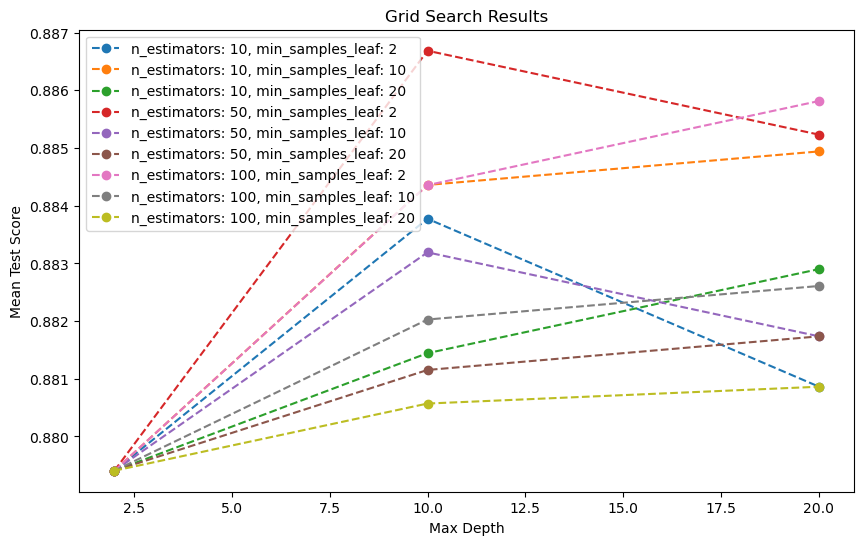

{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 50}


In [122]:
parameters = {"max_depth": [2, 10, 20],
              "min_samples_leaf": [2, 10, 20],
              "n_estimators":[10, 50, 100]}

grid_search = perform_and_plot_RNDForest_grid_search(parameters, X_train, y_train)
print(grid_search.best_params_)

#### 5.3 Second grid search

The parameters 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 50 and performed best in our grid search. We are testing some more parameters around these values in the next grid search, to see if we can get even better results.

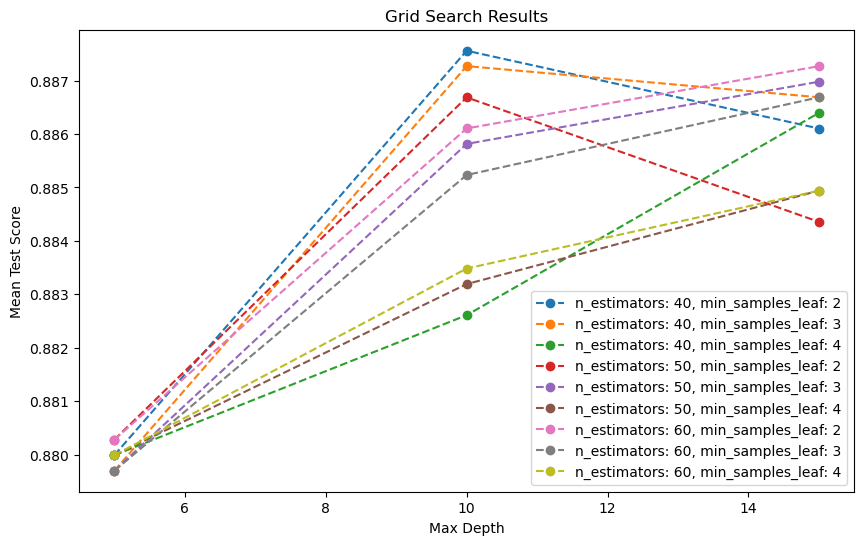

{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 40}


In [123]:
parameters = {"max_depth": [5, 10, 15],
              "min_samples_leaf": [2, 3, 4],
              "n_estimators":[40, 50, 60]}

grid_search = perform_and_plot_RNDForest_grid_search(parameters, X_train, y_train)
print(grid_search.best_params_)

#### 5.4 Final Prarameters

The parameters 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 40 performed even better, but not much. We can narrow down the parameters even more or look for completly different ones, but we might not make a big difference in mean test score. We will stick to the parameters we found in this grid search.

In [124]:
# train model
model = RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=40, random_state=42)
model.fit(X_train, y_train)

y_train_preds = model.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = model.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.9961347856490216
Val C-Index: 0.8680860670684056


We were able to get a higher C-index compared to our [first training](#first_training) (0.868 compared to 0.854). But its not much. We can see that the model is still overfitting, because the training score is higher than the validation score. We can try to reduce the overfitting by reducing the max_depth and min_samples_leaf. But we will not get a much better model, because the validation score is already high.

#### 5.5 Evaluation

- Evaluate the model using accuracy, confusion matrix, f1-score, and ROC curve
- How good is the model? What are the main problems?

##### helper functions

In [125]:
from sklearn import metrics

def plot_confusion_matrix(confusion_matrix):
    # Plot the confusion matrix using Seaborn's heatmap
    plt.figure(figsize=(6, 4), dpi=50)
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 16},
               cmap="Purples",
               fmt="g")

    # Set labels and title
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title('Confusion Matrix', fontsize=20)

    # Show the plot
    plt.show()
    
    
def plot_roc_curve(labels, predicted_labels):
    # Calculate the false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, _ = metrics.roc_curve(labels, predicted_labels)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(8, 8), dpi=50)
    ax.plot(fpr, tpr, color='cornflowerblue', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2,
            linestyle='--')  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    plt.legend(loc="lower right", fontsize=14)
    plt.grid(True)

    # Show the plot
    plt.show()


def evaluate_model(model, X_validation, y_validation):
    y_predicted = model.predict(X_validation)
    y_probability = model.predict_proba(X_validation)[:,1]
    
    print(f"C-Index   :  {cindex(y_validation.values, y_probability)}")
    
    stupid_predictions = np.zeros(len(y_validation))

    accuracy = metrics.accuracy_score(y_validation, stupid_predictions)
    print("Baseline  : ", accuracy)
    accuracy = metrics.accuracy_score(y_validation, y_predicted)
    print("Accuracy  : ", accuracy)
    
    print("f1 sore   : ", metrics.f1_score(y_validation, y_predicted))
    
    #print("Condusion matrix: ")
    plot_confusion_matrix(sklearn.metrics.confusion_matrix(y_validation, y_predicted))
    
    #print("ROC curve: ")
    plot_roc_curve(y_validation, y_predicted)    
    
    plot_roc_curve(y_validation, y_probability)
    print("Probability mean: ", y_probability.mean())

##### Evaluation

C-Index   :  0.8680860670684056
Baseline  :  0.8790760869565217
Accuracy  :  0.8872282608695652
f1 sore   :  0.1443298969072165


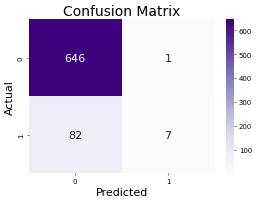

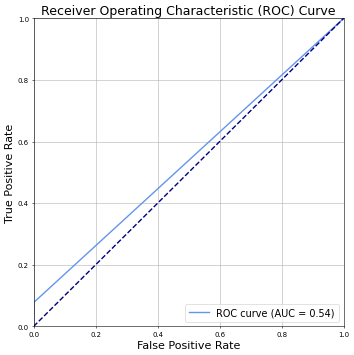

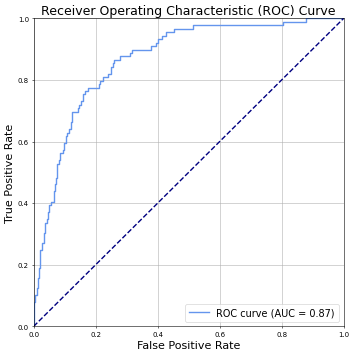

Probability mean:  0.11266842407109834


In [126]:
evaluate_model(model, X_val, y_val)

The model is not very good at predicting diabetes. We can see that its accuracy is not much better than just guessing that nobody has diabetes.
The confusion matrix shows that the model is focusing on keeping the false positive predictions low. But we get 82 false negatives and only 7 true negatives. So the Recall is very low.
Therefore the f1-score is low too, since its calculated out of Recall and Precision of the model. The Precision isn't too bad, since the model only predicted one false positive. But overall this isn't helping, because we don't want to miss so many diabetes diagnoses.Diagnosing diabetes is what this model should do after all.
The AUC of the ROC-Curve is 0.54, which means that the model is not much better than random guessing.


---
### 6. Check if labels are balanced
- If you find that the data is not balanced enough, try to mitigate this problem (e.g. by oversampling or adding class weights).
- Use any hyperparameter search strategy you know (grid search, random search, or Bayesian search)
- Again use the same evaluation metrics as above to inspect the quality of your model.

In [127]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

0    3019
1     414
Name: diabetes, dtype: int64
0    647
1     89
Name: diabetes, dtype: int64
0    638
1     98
Name: diabetes, dtype: int64


The labels are clearly not balanced and are strongly biased towards the negative class. The second ROC-Curve shows that we could get almost into the upper left square of the diagram, which would result in high recall and high precision, if we find the right class weights. But we will try to oversample the positive class first and do a grid search for the best parameters on the oversampled model to see if we can get the ROC-Curve even further into the upper left square.

#### Oversampling

In [128]:
# echte Kopie des models erstellen (nicht nur Verweise)
train_data = X_train.copy(deep=True)
# sicherstellen, dass die Reihenfolge der Daten gleich bleibt
train_data["label"] = y_train

# true is unterrepräsentiert, false ist überrepräsentiert
minority_class = train_data[train_data.label == True]
majority_class = train_data[train_data.label == False]
minority_class.shape, majority_class.shape

((414, 29), (3019, 29))

In [129]:
from sklearn.utils import resample

# wir möchten, dass unsere unterrepräsentierte Klasse genauso groß wird, wie unsere überrepräsentierte
minority_class_oversampled = resample(minority_class, 
                                      n_samples=len(majority_class),
                                      replace=True,
                                      random_state=0
                                      )
minority_class_oversampled.shape

(3019, 29)

In [130]:
train_data_oversampled = pd.concat([majority_class, minority_class_oversampled])

X_train_oversampled = train_data_oversampled.drop(["label"], axis=1)
y_train_oversampled = train_data_oversampled["label"]

print("True: ", y_train_oversampled.sum())
print("False: ", len(y_train_oversampled) - y_train_oversampled.sum())

X_train_oversampled.describe()

True:  3019
False:  3019


,SEQN,Gender,AgeInYearsAtScreening,HaveSeriousDifficultySeeing,HaveSeriousDifficultyHearing,WeightKg,StandingHeightCm,BodyMassIndexKgm2,BloodMercuryTotalUgl,BloodManganeseUgl,...,TotalFatGm_DR1TOT,TotalSugarsGm_DR1TOT,BloodLeadUgdl,60SecPulse30SecPulse2,DirectHdlcholesterolMgdl,TotalCholesterolMgdl,SystolicBloodPres2NdRdgMmHg,Smoking,PhysicalActivity,diabetes_borderline
count,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,...,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000,6038.000000
mean,98330.609639,0.459092,50.881749,0.099702,0.112951,82.858546,165.351226,29.996191,1.285306,9.902486,...,82.823500,101.683662,1.169664,73.203047,51.063597,179.275257,126.409738,0.161477,0.598211,0.014906
std,2655.254775,0.498365,21.192898,0.299627,0.316559,25.543585,11.428277,8.035114,2.604833,3.650129,...,47.213961,72.747159,1.175074,11.949129,14.790814,43.878143,20.806237,0.368001,0.695862,0.121185
min,93707.000000,0.000000,8.000000,0.000000,0.000000,18.600000,115.900000,13.200000,0.200000,1.570000,...,0.590000,0.600000,0.050000,42.000000,10.000000,79.000000,80.000000,0.000000,0.000000,0.000000
25%,96096.250000,0.000000,35.000000,0.000000,0.000000,65.800000,157.700000,24.700000,0.310000,7.470000,...,50.920000,51.390000,0.530000,64.000000,41.000000,149.000000,112.000000,0.000000,0.000000,0.000000
50%,98369.000000,0.000000,57.000000,0.000000,0.000000,80.700000,165.500000,28.900000,0.600000,9.290000,...,74.380000,86.080000,0.890000,72.000000,48.000000,176.000000,124.000000,0.000000,0.000000,0.000000
75%,100576.000000,1.000000,67.000000,0.000000,0.000000,95.800000,173.300000,34.100000,1.350000,11.600000,...,104.440000,132.745000,1.360000,80.000000,59.000000,205.000000,138.000000,0.000000,1.000000,0.000000
max,102954.000000,1.000000,80.000000,1.000000,1.000000,204.400000,195.800000,74.800000,63.640000,52.000000,...,567.960000,931.160000,22.010000,134.000000,178.000000,431.000000,228.000000,1.000000,2.000000,1.000000


#### Oversampled Grid Search

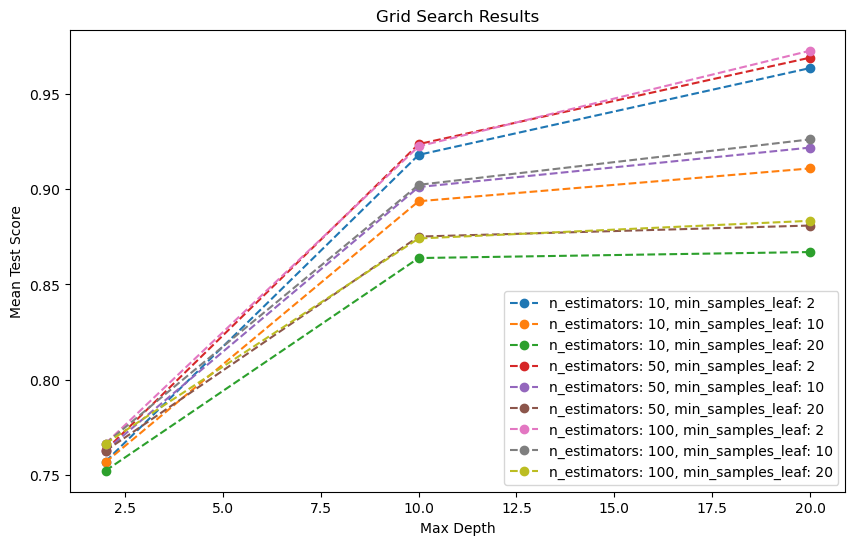

{'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 100}


In [131]:
# using the same parameters as for our very first grid search
parameters = {"max_depth": [2, 10, 20],
              "min_samples_leaf": [2, 10, 20],
              "n_estimators":[10, 50, 100]}
oversampled_grid_search = perform_and_plot_RNDForest_grid_search(parameters, X_train_oversampled, y_train_oversampled)
print(oversampled_grid_search.best_params_)

We get a much higher mean test score, and it is clear that the min_samples_leaf parameter is the most important one. The fewer the better.
The max_depth seems to produce better results with high values. 
The n_estimator parameter seems to get better with higher values too, but only very slightly when using lesser min_samples_leaf values. 
We will do another grid search with 2 to 4 min_samples_leaf and higher max_depth to see if we can get even better results.
We will just use 50 and 200 for n_estimators, because 50 will liekly produce good results but lets see where 200 can take us.

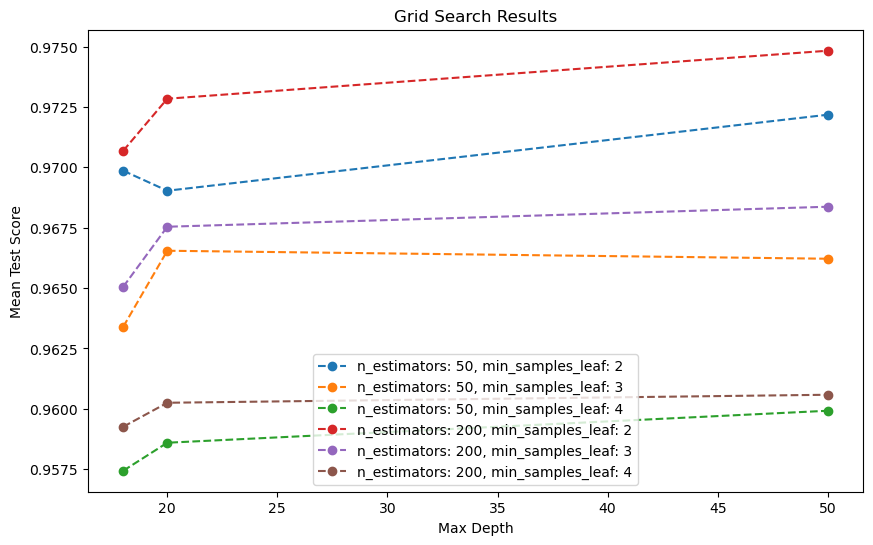

{'max_depth': 50, 'min_samples_leaf': 2, 'n_estimators': 200}


In [132]:
parameters = {"max_depth": [18, 20, 50],
              "min_samples_leaf": [2, 3, 4],
              "n_estimators":[50, 200]}
oversampled_grid_search = perform_and_plot_RNDForest_grid_search(parameters, X_train_oversampled, y_train_oversampled)
print(oversampled_grid_search.best_params_)

#### Oversampled Grid Search Evaluation

C-Index   :  0.8636142611534654
Baseline  :  0.8790760869565217
Accuracy  :  0.8953804347826086
f1 sore   :  0.3529411764705882


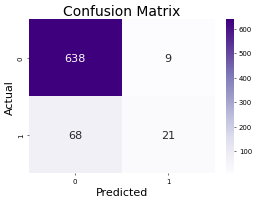

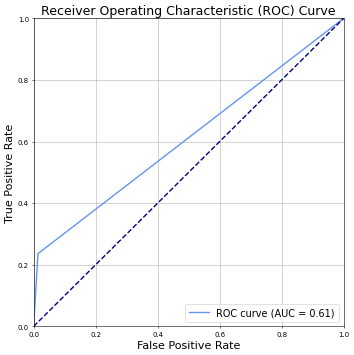

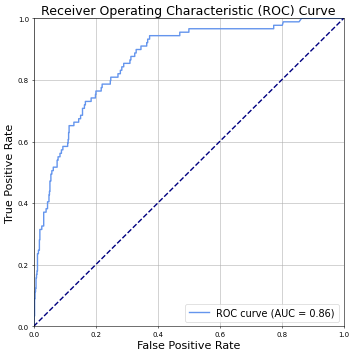

Probability mean:  0.1570936369720818


In [133]:
# train with the best parameters found in the grid search
model_oversampled = RandomForestClassifier(max_depth = 50, min_samples_leaf = 2, n_estimators = 200, random_state=42)
model_oversampled.fit(X_train_oversampled, y_train_oversampled)

# evaluate oversampled model
evaluate_model(model_oversampled, X_val, y_val)

The AUC is actually a little bit lower than in our non-oversampled model. That means that the oversampling hasn't achieved much. We will instead try to find the best class weights for our model since this approach is faster and easier.

#### Class Weights

We use the best parameters from the second grid search again.

#### high f1 Score

With class weights of 1:18.5 we get a high f1 score of 0.46.

C-Index   :  0.8406734626539083
Baseline  :  0.8790760869565217
Accuracy  :  0.7948369565217391
f1 sore   :  0.4626334519572954


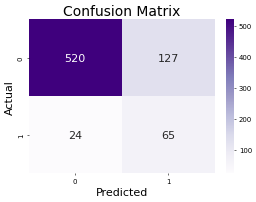

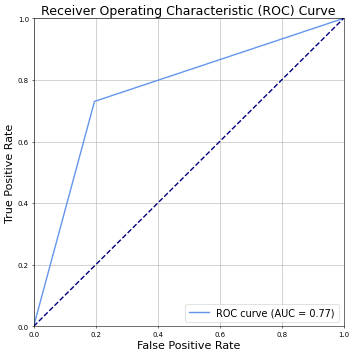

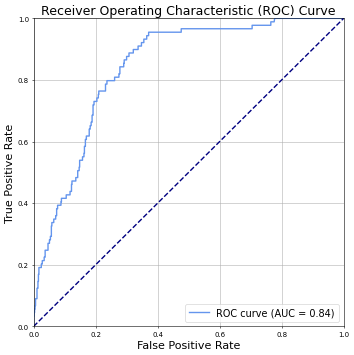

Probability mean:  0.28466968644113166


In [134]:
class_weights={False: 1, True:18.5}

# train with the best parameters found in the second grid search
weighted_model = RandomForestClassifier(max_depth = 10,
                                        min_samples_leaf = 2,
                                        n_estimators = 40,
                                        random_state=42,
class_weight=class_weights)
# AUc: 0.78, f1:0.45 {False: 1, True:2.4})
# auc: 0.79, f1:0.44 {False: 1, True:3.3})
weighted_model.fit(X_train, y_train)

# pred = weighted_model.predict(X_val)
# plot_roc_curve(y_val, pred)
# evaluate model
evaluate_model(weighted_model, X_val, y_val)

#### high AUC 

But with class weights of 1:42 (False:True) we get a high AUC of 0.79. 

C-Index   :  0.8424100863101958
Baseline  :  0.8790760869565217
Accuracy  :  0.7119565217391305
f1 sore   :  0.42702702702702694


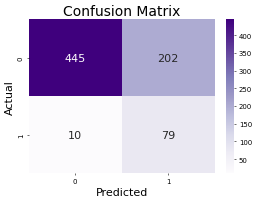

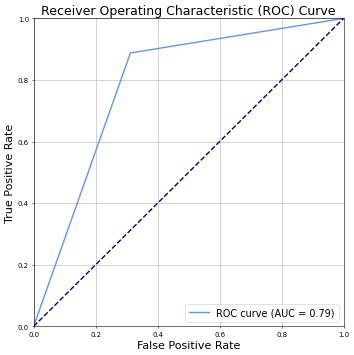

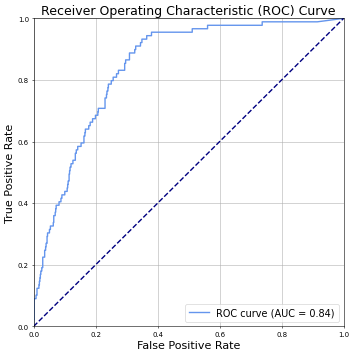

Probability mean:  0.37326652147877776


In [135]:
class_weights={False: 1, True:42}

# train with the best parameters found in the second grid search
final_model = RandomForestClassifier(max_depth = 10,
                                        min_samples_leaf = 2,
                                        n_estimators = 40,
                                        random_state=42,
                                        class_weight=class_weights)

final_model.fit(X_train, y_train)

# evaluate model
evaluate_model(final_model, X_val, y_val)

We can see that we still have a lot of false positives (202), but if this model would be used in practice, it is better to do a second testing with conventional matters on a false positive patient, than to miss a diabetes diagnosis. So we will stick to the high AUC model. 

---
### 7. Explainability
- Use SHAP to plot the importance of each feature for the predictions
- Use SHAP for two individual predictions (one person with diabetes predicted, one person with lower risk)

- Small check: Train another model (same hyperparameters), but remove the data of the 10 least important features. How does this affect your model performance?


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


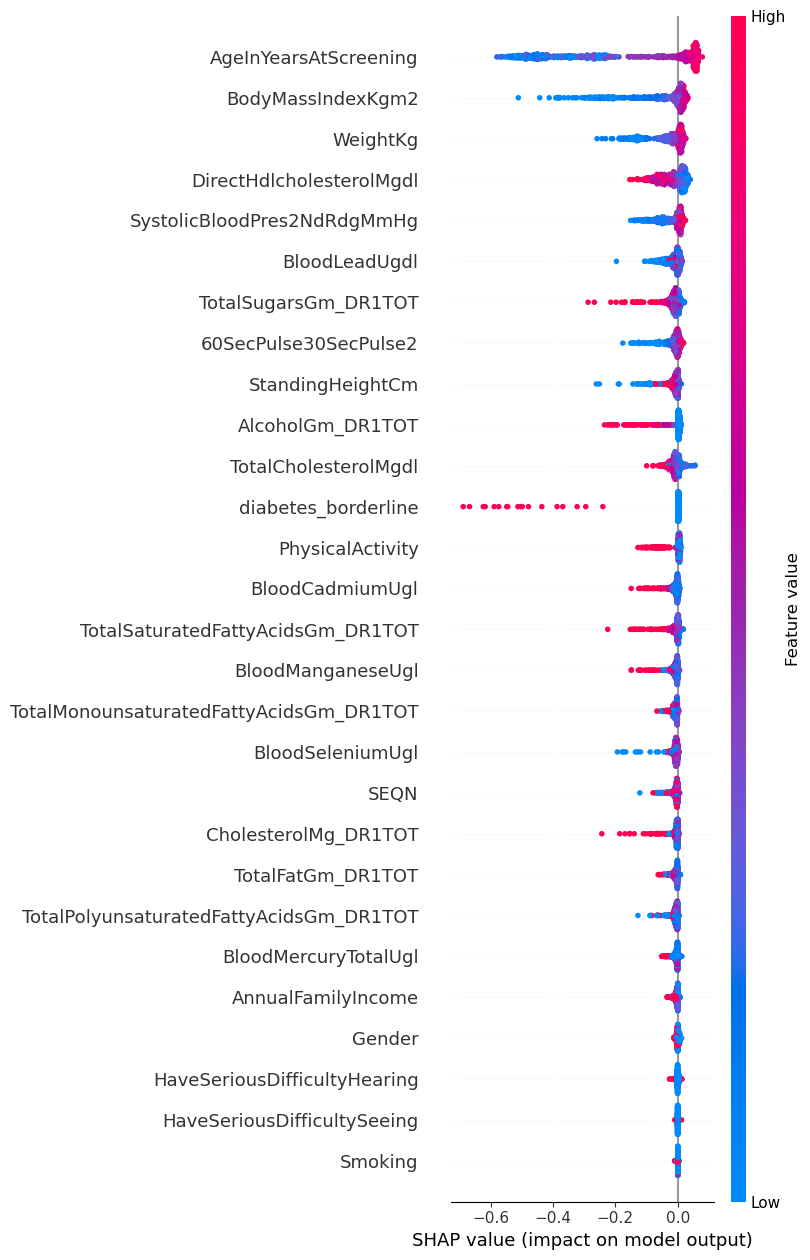

In [136]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)[1]
shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])

The shap summary plot shows that Age, BMI and weight are the most important features for the model.

#### Indiviual with diabetes prediction

In [137]:
# create dataframe with risk predictions
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'predicted_risk'] = final_model.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='predicted_risk', ascending=False)
X_test_risk.head()

,SEQN,Gender,AgeInYearsAtScreening,HaveSeriousDifficultySeeing,HaveSeriousDifficultyHearing,WeightKg,StandingHeightCm,BodyMassIndexKgm2,BloodMercuryTotalUgl,BloodManganeseUgl,...,TotalSugarsGm_DR1TOT,BloodLeadUgdl,60SecPulse30SecPulse2,DirectHdlcholesterolMgdl,TotalCholesterolMgdl,SystolicBloodPres2NdRdgMmHg,Smoking,PhysicalActivity,diabetes_borderline,predicted_risk
2638,96607.0,0,71.0,0.0,0.0,120.1,184.8,35.2,0.50,10.08,...,73.66,1.02,72.0,41.0,153.0,154.0,0,0.0,0,0.965442
978,94779.0,0,80.0,0.0,1.0,87.7,171.4,29.9,7.48,9.49,...,55.26,1.12,68.0,36.0,139.0,130.0,0,0.0,0,0.963734
727,94500.0,1,60.0,0.0,0.0,101.1,168.7,35.5,1.13,8.89,...,68.07,0.97,62.0,43.0,127.0,142.0,0,1.0,0,0.963549
2011,95917.0,1,74.0,0.0,0.0,95.0,163.8,35.4,0.82,14.31,...,112.66,1.22,68.0,41.0,133.0,156.0,0,1.0,0,0.956416
3382,97428.0,0,77.0,0.0,0.0,88.9,166.2,32.2,0.20,12.27,...,108.61,0.80,78.0,46.0,161.0,144.0,0,0.0,0,0.956369


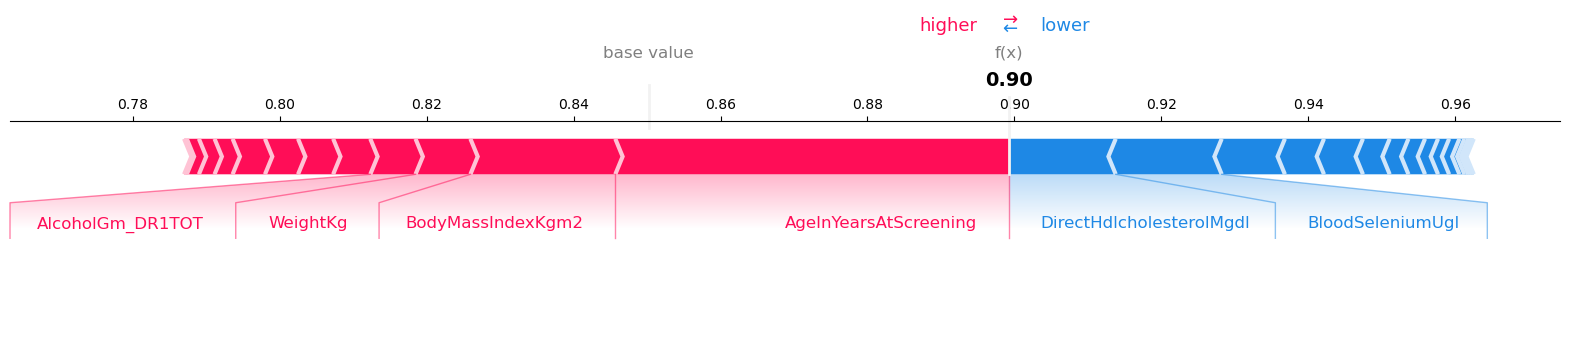

SEQN                                       9.476800e+04
Gender                                     0.000000e+00
AgeInYearsAtScreening                      8.000000e+01
HaveSeriousDifficultySeeing                0.000000e+00
HaveSeriousDifficultyHearing               0.000000e+00
WeightKg                                   9.830000e+01
StandingHeightCm                           1.684000e+02
BodyMassIndexKgm2                          3.470000e+01
BloodMercuryTotalUgl                       1.460000e+00
BloodManganeseUgl                          8.670000e+00
BloodSeleniumUgl                           2.364200e+02
BloodCadmiumUgl                            1.200000e-01
AnnualFamilyIncome                         6.000000e+04
AlcoholGm_DR1TOT                           5.397605e-79
CholesterolMg_DR1TOT                       2.370000e+02
TotalPolyunsaturatedFattyAcidsGm_DR1TOT    1.980900e+01
TotalMonounsaturatedFattyAcidsGm_DR1TOT    1.614600e+01
TotalSaturatedFattyAcidsGm_DR1TOT          1.808

In [138]:
# patients with low indices in the sorted risk dataframe are predicted to be at high risk
high_risk_patient_index = X_test_risk.index[42]
#print(X_test.loc[high_risk_patient_index, :].SEQN)
#print(X_test_risk.loc[high_risk_patient_index, :].SEQN)

# plot shap force plot for a high risk patient
shap_value = explainer.shap_values(X_test.loc[high_risk_patient_index, :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

# print values for a high risk patient
X_test_risk.loc[high_risk_patient_index, :]

The shap force plot shows that this patient got a high prediction, because of his high age, BMI and weight. Which is in line with the shap summary plot. The DirectHdlchorestorolMgdl feature, which is the forth most important global feature, has an negative impact on the prediction, but the others still overweigh this.

#### Indiviual with lower risk prediction

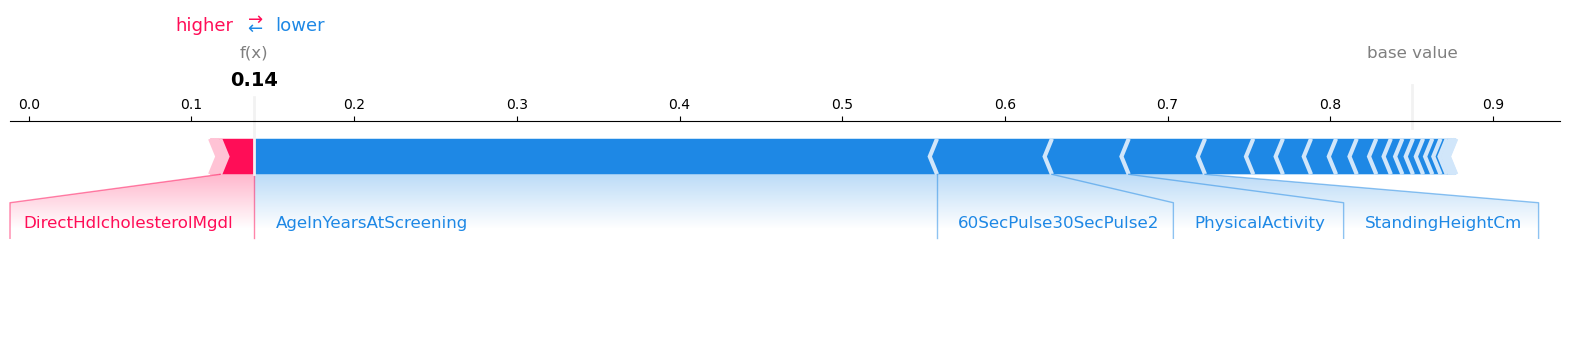

SEQN                                       9.585800e+04
Gender                                     0.000000e+00
AgeInYearsAtScreening                      3.200000e+01
HaveSeriousDifficultySeeing                0.000000e+00
HaveSeriousDifficultyHearing               0.000000e+00
WeightKg                                   8.630000e+01
StandingHeightCm                           1.765000e+02
BodyMassIndexKgm2                          2.770000e+01
BloodMercuryTotalUgl                       2.000000e-01
BloodManganeseUgl                          7.850000e+00
BloodSeleniumUgl                           1.815900e+02
BloodCadmiumUgl                            1.300000e-01
AnnualFamilyIncome                         8.750000e+04
AlcoholGm_DR1TOT                           5.397605e-79
CholesterolMg_DR1TOT                       9.500000e+01
TotalPolyunsaturatedFattyAcidsGm_DR1TOT    2.839500e+01
TotalMonounsaturatedFattyAcidsGm_DR1TOT    3.083700e+01
TotalSaturatedFattyAcidsGm_DR1TOT          2.582

In [139]:
# patients at the end of the sorted risk dataframe are predicted to be at low risk
low_risk_patient_index = X_test_risk.index[-242]

# plot shap force plot for low risk patient
shap_value = explainer.shap_values(X_test.loc[low_risk_patient_index, :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

# print values for a high risk patient
X_test_risk.loc[low_risk_patient_index, :]

The shap force plot shows that this patient got a low prediction, because he is only 32, has a good pulse and is physically active.

#### create Model with 10 least important features removed

In [140]:
# feature importance array
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
# 10 least important features
feature_importance[-10:]

,col_name,feature_importance_vals
0,SEQN,0.008816
14,CholesterolMg_DR1TOT,0.008692
18,TotalFatGm_DR1TOT,0.008205
15,TotalPolyunsaturatedFattyAcidsGm_DR1TOT,0.008136
8,BloodMercuryTotalUgl,0.005643
12,AnnualFamilyIncome,0.004556
1,Gender,0.002729
4,HaveSeriousDifficultyHearing,0.002300
3,HaveSeriousDifficultySeeing,0.000945
25,Smoking,0.000580


In [141]:
# drop 10 least important features
X_train_important_only = X_train.copy(deep=True)
for col in X_train_important_only.columns:
    if col in feature_importance[-10:].col_name.values:
        X_train_important_only.drop(col, axis=1, inplace=True)

# show important features
X_train_important_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3433 entries, 566 to 1452
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   AgeInYearsAtScreening                    3433 non-null   float64
 1   WeightKg                                 3433 non-null   float64
 2   StandingHeightCm                         3433 non-null   float64
 3   BodyMassIndexKgm2                        3433 non-null   float64
 4   BloodManganeseUgl                        3433 non-null   float64
 5   BloodSeleniumUgl                         3433 non-null   float64
 6   BloodCadmiumUgl                          3433 non-null   float64
 7   AlcoholGm_DR1TOT                         3433 non-null   float64
 8   TotalMonounsaturatedFattyAcidsGm_DR1TOT  3433 non-null   float64
 9   TotalSaturatedFattyAcidsGm_DR1TOT        3433 non-null   float64
 10  TotalSugarsGm_DR1TOT                     3433 

In [142]:
# train model for small check
small_check_model = RandomForestClassifier(max_depth = 10,
                                          min_samples_leaf = 2,
                                          n_estimators = 40,
                                          random_state=42,
                                          class_weight={False:1, True:42})
small_check_model.fit(X_train_important_only, y_train)

RandomForestClassifier(class_weight={False: 1, True: 42}, max_depth=10,
                       min_samples_leaf=2, n_estimators=40, random_state=42)

#### Evaluation of small check model

C-Index   :  0.8079857334783443
Baseline  :  0.8668478260869565
Accuracy  :  0.6834239130434783
f1 sore   :  0.4189526184538654


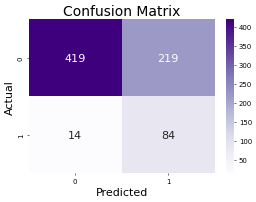

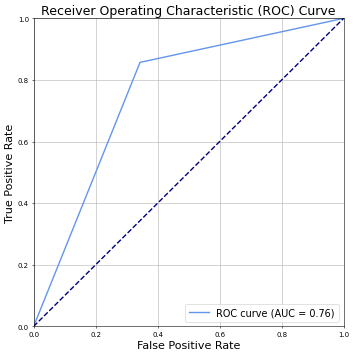

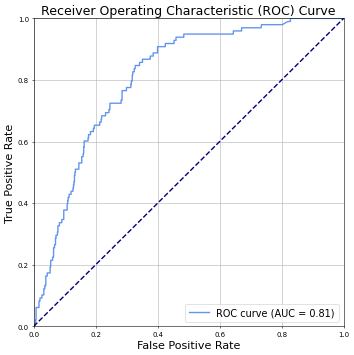

Probability mean:  0.3886997159807434


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


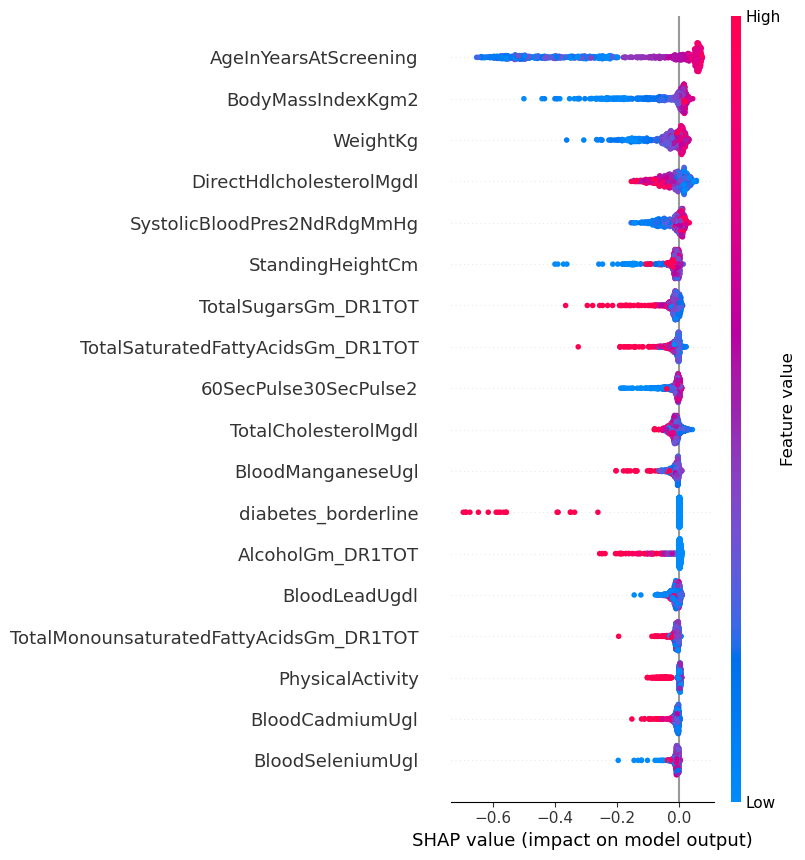

In [143]:
evaluate_model(small_check_model, X_test[X_train_important_only.columns], y_test)

small_check_explainer = shap.TreeExplainer(small_check_model)
shap_values = small_check_explainer.shap_values(X_test[X_train_important_only.columns])[1]
shap.summary_plot(shap_values, X_test[X_train_important_only.columns], max_display=X_test.shape[1])

The small check shows that the model is not much worse without the 10 least important features, which speaks for a high consistency of the model.

---
### 8. Conclusion
- How good is your model? How well can you predict diabetes?
- Could such a model be improved further? If so, what could be done to improve the model?
- Compare your results to current research [Dinh et al., 2019](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-019-0918-5). Obviously, it is not 100% the same data, but somewhat comparable. Two specific questions to answer: Is your model of comparable type to what they used in their study? And did you get a comparable model performance?

#### Evaluation of final model against test data

C-Index   :  0.7933273622928795
Baseline  :  0.8668478260869565
Accuracy  :  0.6725543478260869
f1 sore   :  0.40786240786240785


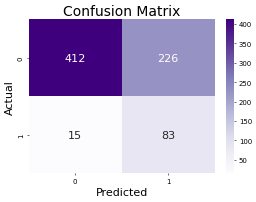

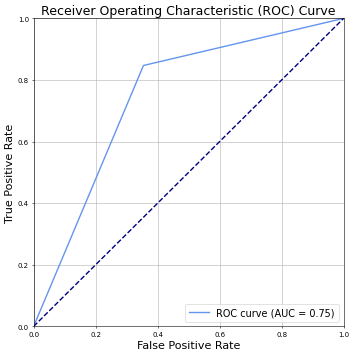

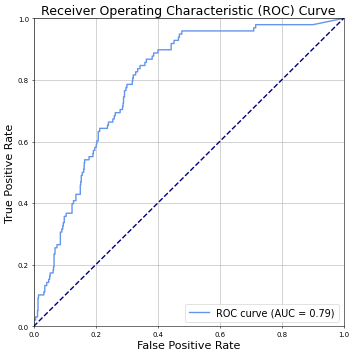

Probability mean:  0.399941608817065


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


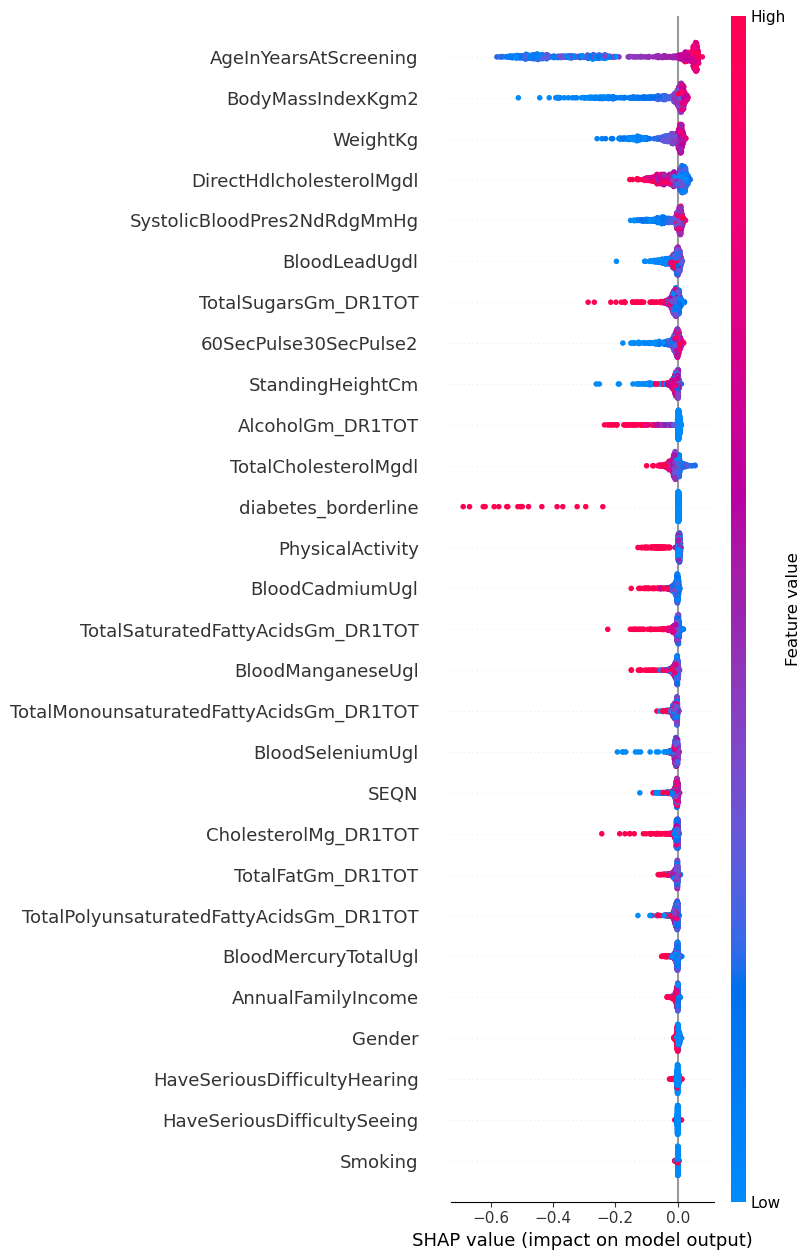

In [144]:
# evaluate model
evaluate_model(final_model, X_test, y_test)

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)[1]
shap.summary_plot(shap_values, X_test, max_display=30)

Evaluating the model on the test data shows, that it is not very good. We can see that we still have a lot of false positives (226), and 15 diabetic patients got a negative prediction.  
Using more data for training would be the best way of improving the model.  

Dinh et al. used several different machine learning approaches including random forests such as our model. They  also use the NHANES dataset, so they trained their models on the same features as we did, but their data was collected during a different time frame. They split up their data to test their models on different sets of features. The feature set comparable to our data would be the _laboratory_ one. And they split up their labels into two cases. _Case I_ is the one with positive and negative diabetes diagnoses such as in our training.  

In comparison to the Random Forest trained on lab data in the Case I scenario of Dinh et al. it shows that our model has a significantly lower AUC (0.937 vs. 0.75) and f1 score (0.86 vs. 0.41) ([Table 5](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-019-0918-5/tables/5)). It follows that Dinh et al. clearly outperforms our model.